In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X.npy')
y=np.load('data_y.npy')

In [3]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [5]:
from keras import models, layers
from keras import Input
from keras.applications import InceptionV3
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = InceptionV3(weights=None, include_top=False, input_shape=(224, 224, 3))
model.trainable = True
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [6]:
#customizing my layers
additional_model = models.Sequential()
additional_model.add(model)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4, activation='softmax'))

additional_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204804    
Total params: 22,007,588
Trainable params: 21,973,156
Non-trainable params: 34,432
_________________________________________________________________


In [7]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [8]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='Inception v3_1.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)

In [9]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(), f1score])

In [10]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=150, 
            epochs=40, 
            validation_data=(X_val,y_val), 
            validation_steps=32, 
            callbacks=[checkpoint])

Epoch 1/40
150/150 [==============================] - 67s 444ms/step - loss: 1.0740 - acc: 0.5006 - auc: 0.7280 - precision: 0.5243 - recall: 0.2578 - f1score: 0.1391 - val_loss: 1.9425 - val_acc: 0.1839 - val_auc: 0.7669 - val_precision: 0.5437 - val_recall: 0.3218 - val_f1score: 0.0921
Epoch 2/40
150/150 [==============================] - 43s 285ms/step - loss: 0.9126 - acc: 0.5539 - auc: 0.7760 - precision: 0.5418 - recall: 0.3448 - f1score: 0.1553 - val_loss: 2.5286 - val_acc: 0.2293 - val_auc: 0.7826 - val_precision: 0.5420 - val_recall: 0.3696 - val_f1score: 0.0823
Epoch 3/40
150/150 [==============================] - 44s 294ms/step - loss: 0.8595 - acc: 0.5740 - auc: 0.7862 - precision: 0.5415 - recall: 0.3869 - f1score: 0.1601 - val_loss: 2.0083 - val_acc: 0.3260 - val_auc: 0.7938 - val_precision: 0.5467 - val_recall: 0.4034 - val_f1score: 0.1006
Epoch 4/40
150/150 [==============================] - 43s 286ms/step - loss: 0.8286 - acc: 0.5828 - auc: 0.7996 - precision: 0.5518 -

150/150 [==============================] - 43s 287ms/step - loss: 0.6408 - acc: 0.6798 - auc: 0.8812 - precision: 0.6338 - recall: 0.5758 - f1score: 0.1809 - val_loss: 1.2213 - val_acc: 0.5763 - val_auc: 0.8816 - val_precision: 0.6344 - val_recall: 0.5769 - val_f1score: 0.1638
Epoch 30/40
150/150 [==============================] - 42s 282ms/step - loss: 0.6361 - acc: 0.6710 - auc: 0.8820 - precision: 0.6349 - recall: 0.5779 - f1score: 0.1802 - val_loss: 1.4191 - val_acc: 0.6112 - val_auc: 0.8824 - val_precision: 0.6356 - val_recall: 0.5791 - val_f1score: 0.1689
Epoch 31/40
150/150 [==============================] - 42s 281ms/step - loss: 0.6387 - acc: 0.6795 - auc: 0.8829 - precision: 0.6364 - recall: 0.5803 - f1score: 0.1812 - val_loss: 1.4102 - val_acc: 0.5634 - val_auc: 0.8833 - val_precision: 0.6370 - val_recall: 0.5814 - val_f1score: 0.1648
Epoch 32/40
150/150 [==============================] - 44s 291ms/step - loss: 0.6451 - acc: 0.6769 - auc: 0.8837 - precision: 0.6376 - recall:

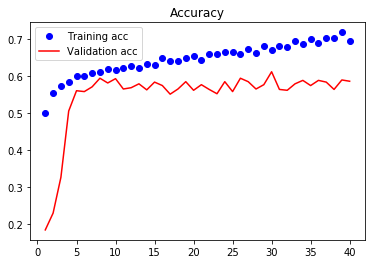

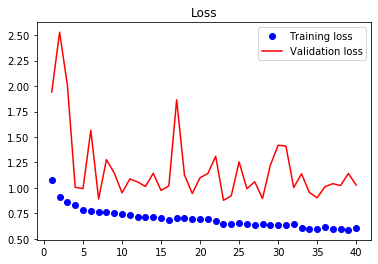

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [12]:
X_test=np.load('X_test.npy')
y_test=np.load('y_test.npy')

In [13]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

859/859 [==============================] - 2s 3ms/step
loss: 1.027, accuracy: 0.586, auc: 0.890, precision: 0.648, recall: 0.600, f1score: 0.168


In [14]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_test, y_test, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

704/704 [==============================] - 2s 3ms/step
loss: 3582847.392, accuracy: 0.259, auc: 0.890, precision: 0.648, recall: 0.600, f1score: nan


In [15]:
additional_model.save('Inception v3_1.h5')